In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [2]:
# Load data from SQLite database
conn = sqlite3.connect('jobs.db:')
df = pd.read_csv('Job_data.csv')
df.to_sql('AI_jobs', conn, index=False, if_exists='replace')
df = pd.read_sql('SELECT * FROM ai_jobs', conn)


In [3]:
df

,Job titiles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain
0,Communications Manager,98%,365,2546,0.143362,Communication & PR
1,Data Collector,95%,299,2148,0.139199,Data & IT
2,Data Entry,95%,325,2278,0.142669,Administrative & Clerical
3,Mail Clerk,95%,193,1366,0.141288,Leadership & Strategy
4,Compliance Officer,92%,194,1369,0.141709,Medical & Healthcare
...,...,...,...,...,...,...
4701,Singer,5%,686,2798,0.245175,Data & IT
4702,Airport,5%,556,2206,0.252040,Administrative & Clerical
4703,Director,5%,1316,4695,0.280298,Leadership & Strategy
4704,Nurse,5%,710,2594,0.273709,Medical & Healthcare


In [4]:
# Sample dataset 
data = {
    'Job Role': [
        'Data Entry Clerk', 'Radiologist', 'Software Engineer', 'Teacher', 'Customer Service Rep',
        'Taxi Driver', 'CEO', 'Graphic Designer', 'Factory Worker', 'Nurse',
        'Legal Assistant', 'Financial Analyst', 'Retail Cashier', 'Construction Worker',
        'HR Specialist', 'Marketing Manager', 'Delivery Driver', 'Pharmacist',
        'Journalist', 'Therapist'
    ],
    'AI_Impact_Score': [
        0.96, 0.91, 0.55, 0.20, 0.88,
        0.89, 0.08, 0.45, 0.93, 0.35,
        0.87, 0.72, 0.94, 0.29,
        0.40, 0.52, 0.92, 0.77,
        0.70, 0.18
    ]  # 1 = highly automatable, 0 = not
}

# Create DataFrame
Job_df = pd.DataFrame(data)

# Sort for top and bottom 10
top_10_affected = Job_df.sort_values(by='AI_Impact_Score', ascending=False).head(10)
least_10_affected = Job_df.sort_values(by='AI_Impact_Score', ascending=True).head(10)

# Print results
print(" Top 10 Most Affected Jobs by AI:")
print(top_10_affected[['Job Role', 'AI_Impact_Score']], end="\n\n")

print(" Least 10 Affected Jobs by AI:")
print(least_10_affected[['Job Role', 'AI_Impact_Score']])


 Top 10 Most Affected Jobs by AI:
                Job Role  AI_Impact_Score
0       Data Entry Clerk             0.96
12        Retail Cashier             0.94
8         Factory Worker             0.93
16       Delivery Driver             0.92
1            Radiologist             0.91
5            Taxi Driver             0.89
4   Customer Service Rep             0.88
10       Legal Assistant             0.87
17            Pharmacist             0.77
11     Financial Analyst             0.72

 Least 10 Affected Jobs by AI:
               Job Role  AI_Impact_Score
6                   CEO             0.08
19            Therapist             0.18
3               Teacher             0.20
13  Construction Worker             0.29
9                 Nurse             0.35
14        HR Specialist             0.40
7      Graphic Designer             0.45
15    Marketing Manager             0.52
2     Software Engineer             0.55
18           Journalist             0.70


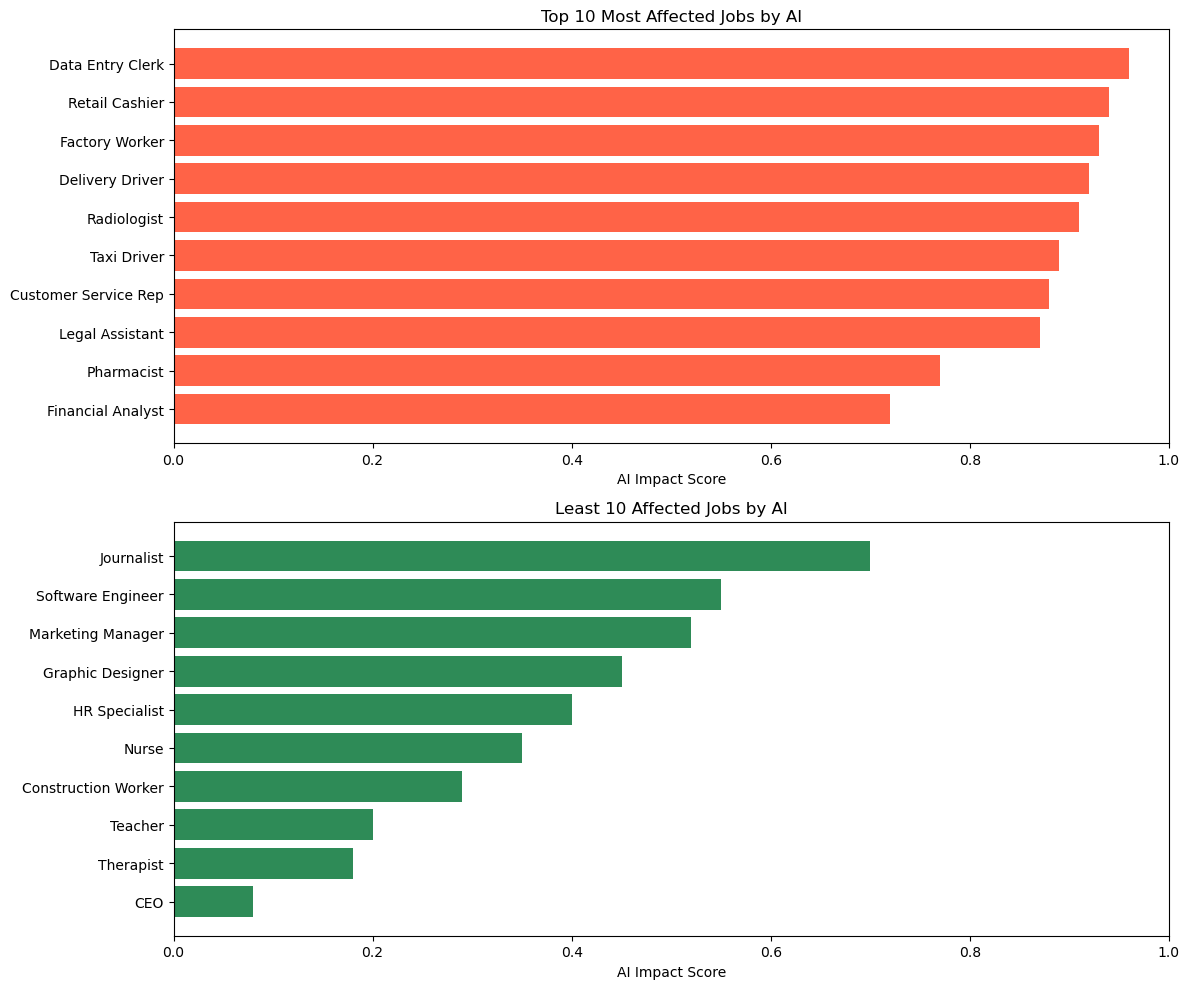

In [5]:
# Create DataFrame
Job_df = pd.DataFrame(data)

# Sort for top and bottom 10
top_10 = Job_df.sort_values(by='AI_Impact_Score', ascending=False).head(10)
least_10 = Job_df.sort_values(by='AI_Impact_Score', ascending=True).head(10)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Top 10 most affected
axes[0].barh(top_10['Job Role'][::-1], top_10['AI_Impact_Score'][::-1], color='tomato')
axes[0].set_title('Top 10 Most Affected Jobs by AI')
axes[0].set_xlabel('AI Impact Score')
axes[0].set_xlim(0, 1)

# Least 10 affected
axes[1].barh(least_10['Job Role'], least_10['AI_Impact_Score'], color='seagreen')
axes[1].set_title('Least 10 Affected Jobs by AI')
axes[1].set_xlabel('AI Impact Score')
axes[1].set_xlim(0, 1)

plt.savefig('Jobs affected by AI Innovations.png', dpi=100, bbox_inches='tight')  

plt.tight_layout()
plt.show()

In [6]:
# Data cleaning
# Convert 'AI Impact' to numeric if necessary and handle missing or infinite values
if df['AI Impact'].dtype == 'object':
    df['AI Impact'] = df['AI Impact'].astype(str).str.extract(r'(\d+\.?\d*)')[0]
    df['AI Impact'] = pd.to_numeric(df['AI Impact'], errors='coerce')

# Convert relevant columns to numeric
for col in ['AI_Workload_Ratio', 'Tasks', 'AI models']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [7]:
# Drop rows with any NaN or infinite values in the selected columns
features = ['AI Impact', 'Tasks', 'AI models', 'AI_Workload_Ratio']
df = df[features].replace([np.inf, -np.inf], np.nan).dropna()


In [8]:
df

,AI Impact,Tasks,AI models,AI_Workload_Ratio
0,98,365,2546,0.143362
1,95,299,2148,0.139199
2,95,325,2278,0.142669
3,95,193,1366,0.141288
4,92,194,1369,0.141709
...,...,...,...,...
4701,5,686,2798,0.245175
4702,5,556,2206,0.252040
4703,5,1316,4695,0.280298
4704,5,710,2594,0.273709


In [9]:
# Display column names one per line
for column in df.columns:
    print(column)


AI Impact
Tasks
AI models
AI_Workload_Ratio


In [10]:
# Attempt 1: Step 4: Preprocess
# Features and target (excluding Job titles and Domain)
X = df[['AI Impact', 'AI models']]
y = df['AI_Workload_Ratio']

# Convert to numeric before scaling (ensure all data is numerical)
X = X.apply(pd.to_numeric)

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [11]:
# Iterative model training and evaluation
results = []
params = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}

best_score = -np.inf
best_model = None
best_pred = None

for n in params['n_estimators']:
    for d in params['max_depth']:
        model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)
        results.append({'n_estimators': n, 'max_depth': d, 'r2_score': score})
        if score > best_score:
            best_score = score
            best_model = model
            best_pred = y_pred

In [12]:
# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('model_optimization_results_1.csv', index=False)

In [13]:
# Print final performance
print("Best R^2 Score:", round(best_score, 4))

Best R^2 Score: 0.6208


In [14]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0024


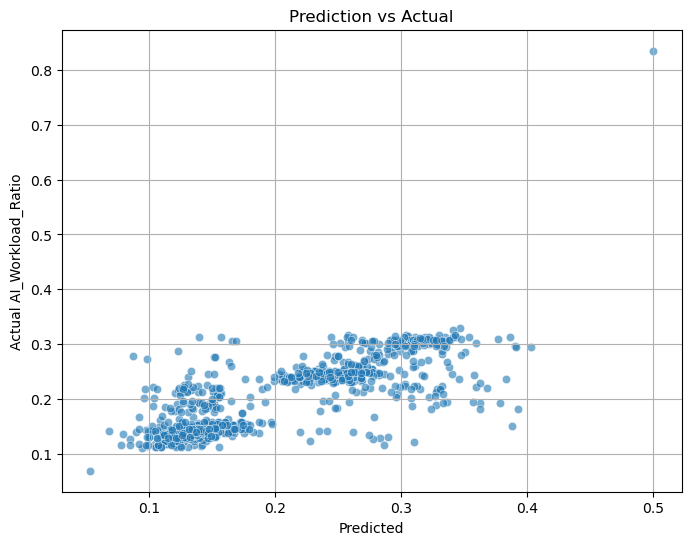

In [15]:
# Plot predictions vs true values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=best_pred, alpha=0.6)
plt.xlabel("Predicted")
plt.ylabel("Actual AI_Workload_Ratio")
plt.title("Prediction vs Actual")
plt.grid(True)

plt.savefig('Prediction vs Actual AI_Workload_Ratio_1.png', dpi=100, bbox_inches='tight')  
    
plt.show()

In [16]:
# Attempt 2: Step 4: Preprocess
# Features and target (excluding Job titles and Domain)
X = df[['AI Impact', 'Tasks']]
y = df['AI_Workload_Ratio']

# Convert to numeric before scaling (ensure all data is numerical)
X = X.apply(pd.to_numeric)

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [17]:
# Iterative model training and evaluation
results = []
params = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}

best_score = -np.inf
best_model = None
best_pred = None

for n in params['n_estimators']:
    for d in params['max_depth']:
        model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)
        results.append({'n_estimators': n, 'max_depth': d, 'r2_score': score})
        if score > best_score:
            best_score = score
            best_model = model
            best_pred = y_pred

In [18]:
# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('model_optimization_results_2.csv', index=False)

In [19]:
# Print final performance
print("Best R^2 Score:", round(best_score, 4))

Best R^2 Score: 0.8275


In [20]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0011


Mean Squared Error (MSE): 0.0011


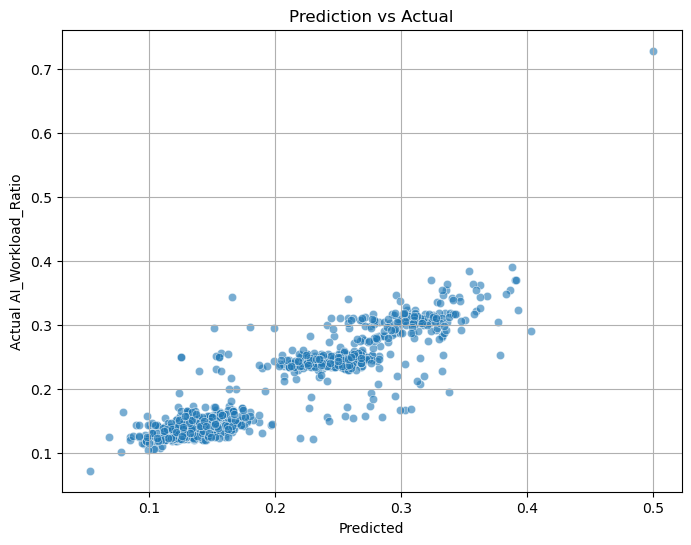

In [21]:
# Plot predictions vs true values
plt.figure(figsize=(8, 6))# Predict on test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
sns.scatterplot(x=y_test, y=best_pred, alpha=0.6)
plt.xlabel("Predicted")
plt.ylabel("Actual AI_Workload_Ratio")
plt.title("Prediction vs Actual")
plt.grid(True)

plt.savefig('Prediction vs Actual AI_Workload_Ratio_2.png', dpi=100, bbox_inches='tight')  
    
plt.show()

In [22]:
# Attempt 3: Step 4: Preprocess
# Features and target (excluding Job titles and Domain)
X = df[['AI Impact', 'Tasks', 'AI models']]
y = df['AI_Workload_Ratio']

# Convert to numeric before scaling (ensure all data is numerical)
X = X.apply(pd.to_numeric)

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [23]:
# Iterative model training and evaluation
results = []
params = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}

best_score = -np.inf
best_model = None
best_pred = None

for n in params['n_estimators']:
    for d in params['max_depth']:
        model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)
        results.append({'n_estimators': n, 'max_depth': d, 'r2_score': score})
        if score > best_score:
            best_score = score
            best_model = model
            best_pred = y_pred


In [24]:
# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('model_optimization_results_3.csv', index=False)


In [25]:
# Print final performance
print("Best R^2 Score:", round(best_score, 4))


Best R^2 Score: 0.9802


In [26]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0001


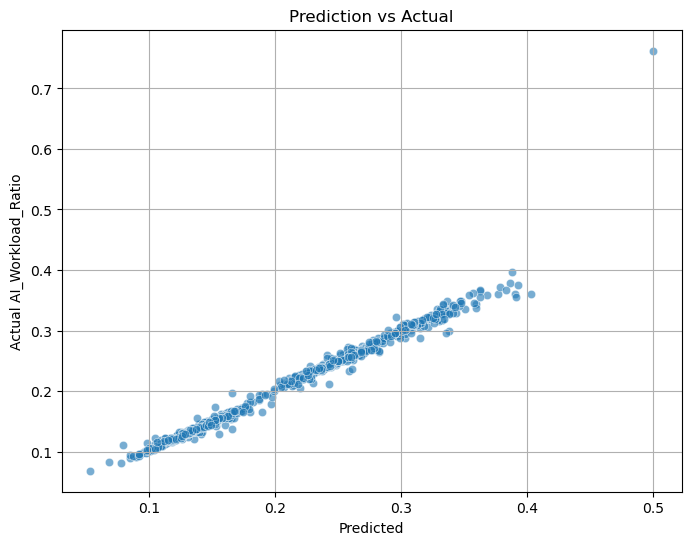

In [27]:
# Plot predictions vs true values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=best_pred, alpha=0.6)
plt.xlabel("Predicted")
plt.ylabel("Actual AI_Workload_Ratio")
plt.title("Prediction vs Actual")
plt.grid(True)

plt.savefig('Prediction vs Actual AI_Workload_Ratio_3.png', dpi=100, bbox_inches='tight')  
    
plt.show()


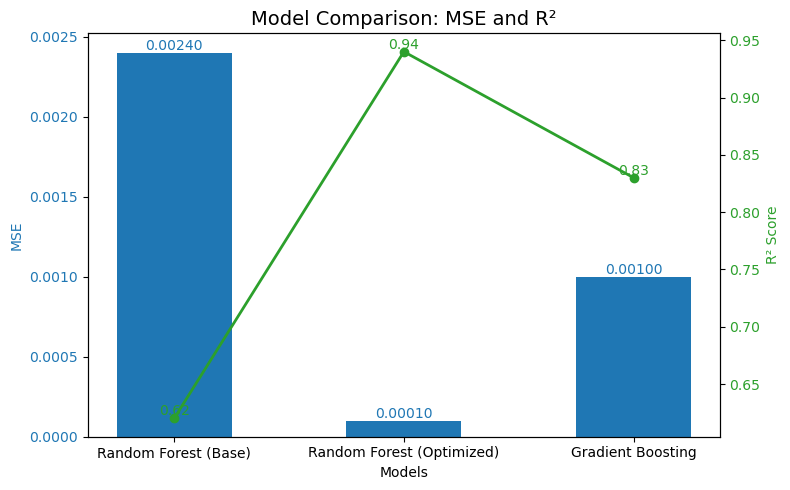

In [28]:
# Example data
data = {
    'Model': ['Random Forest (Base)', 'Random Forest (Optimized)', 'Gradient Boosting'],
    'MSE': [0.0024, 0.0001, 0.001],
    'R2': [0.62, 0.94, 0.83]
}

df = pd.DataFrame(data)

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot for MSE (left axis)
color = 'tab:blue'
ax1.set_xlabel('Models')
ax1.set_ylabel('MSE', color=color)
bars = ax1.bar(df['Model'], df['MSE'], color=color, width=0.5)
ax1.tick_params(axis='y', labelcolor=color)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.5f}', ha='center', va='bottom', color=color)

# Line plot for R2 score (right axis)
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('R² Score', color=color)
line = ax2.plot(df['Model'], df['R2'], color=color, marker='o', linewidth=2, markersize=6)
for i, val in enumerate(df['R2']):
    ax2.text(i, val, f'{val:.2f}', ha='center', va='bottom', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Model Comparison: MSE and R²', fontsize=14)
plt.tight_layout()

plt.savefig('Model Comparison: MSE vs R² Score.png', dpi=100, bbox_inches='tight')  

plt.grid(False)
plt.show()
